In [20]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from rve_utils2 import get_trainer, get_engine_runs, plot_engine_run
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import silhouette_score

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=False, dropout=0, num_layers=1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        self.num_layers = num_layers
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1
            
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.mu = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        self.log_var = nn.Linear(in_features=self.D*hidden_size, out_features=2)
        
        self.regressor = nn.Sequential(nn.Linear(2, 200), nn.Tanh(), nn.Dropout(self.p), nn.Linear(200, 1))
    
    def forward(self, x):
        batch = x.shape[0]
        _, (hn, _) = self.lstm(x)
        """
        hidden.shape = (num_layers*num_directions, batch, hidden_size)
        layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size)
        So you shouldn’t simply do hidden[-1] but first do a view() to separate the num_layers and num_directions (1 or 2). If you do

        hidden = hidden.view(num_layers, 2, batch, hidden_size) # 2 for bidirectional
        last_hidden = hidden[-1]
        then last_hidden.shape = (2, batch, hidden_size) and you can do

        last_hidden_fwd = last_hidden[0]
        last_hidden_bwd = last_hidden[1]
        """
       
        hn = hn.view(self.num_layers, self.D, batch, self.hidden_size)
        
        last_hidden = hn[-1]
        if self.bidirectional:
            out = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        else:
            out = last_hidden[0]
        
        mu = self.mu(out)
        log_var = self.log_var(out)
        
        eps = torch.randn_like(log_var)
        z = mu + eps*torch.exp(0.5*log_var)
        
     
        return z, mu, log_var


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, time_steps=30, bidirectional=False, dropout=0, num_layers=1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        self.num_layers = num_layers
        self.time_steps = time_steps
        if self.bidirectional:
            self.D = 2
        else:
            self.D = 1
        self.lstm = nn.LSTM(input_size=2, hidden_size=self.D*hidden_size, num_layers=num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Sequential(nn.Dropout(self.p), nn.Linear(in_features=self.D*hidden_size, out_features=input_size))
        
    def forward(self, z):
        x_hat = z.unsqueeze(1).repeat(1, self.time_steps, 1)
        x_hat, _ = self.lstm(x_hat)
        x_hat = self.fc(x_hat)
        return x_hat
    
    
class ERVE(nn.Module):
    
    @staticmethod
    def score(y, y_hat):
        score = 0
        y = y.cpu()
        y_hat = y_hat.cpu()
        for i in range(len(y_hat)):
            if y[i] <= y_hat[i]:
                score += np.exp(-(y[i] - y_hat[i]) / 10.0) - 1
            else:
                score += np.exp((y[i] - y_hat[i]) / 13.0) - 1
        return score

    @staticmethod
    def dkl_loss(mean, log_var):
        loss = (-0.5 * (1 + log_var - mean ** 2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        return loss

    @staticmethod
    def regression_loss(y, y_hat):
        criterion = nn.MSELoss()
        return  criterion(y, y_hat)

    @staticmethod
    def reconstruction_loss(x, x_hat):
        batch_size = x.shape[0]
   
        criterion = nn.MSELoss(reduction='none')
        loss = criterion(x, x_hat)
        loss = loss.view(batch_size, -1).sum(axis=1)
        loss = loss.mean()
        return loss
    
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 bidirectional=False, 
                 dropout=0, 
                 num_layers=1,
                 reg_fc_dim=200,
                 decode_mode = True,
                 reg_loss = True,
                 kl_loss=True, 
                 recon_loss=False,  
                 custom_kl_loss=None, 
                 custom_reg_loss=None, 
                 custom_recon_loss=None
                ):
        super(ERVE, self).__init__()
        self.decode_mode = decode_mode
        if self.decode_mode:
            if recon_loss == False:
                recon_loss = True
                print(f"decon_mode overrides recon_loss to: {recon_loss}")
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.p = dropout
        
        self.num_layers = num_layers
        self.reg_loss = reg_loss
        self.kl_loss = kl_loss
        self.rec_loss = recon_loss
        if custom_reg_loss is not None:
            self.reg_loss_criterion = custom_reg_loss
        else:
            self.reg_loss_criterion = ERVE.regression_loss
        if custom_kl_loss is not None:
            self.kl_loss_criterion = custom_kl_loss
        else:
            self.kl_loss_criterion = ERVE.dkl_loss
        if custom_recon_loss is not None:
            self.recon_loss_criterion = custom_recon_loss
        else:
            self.recon_loss_criterion = ERVE.reconstruction_loss
            
        self.encoder = Encoder(input_size, hidden_size, bidirectional=False, dropout=dropout, num_layers=1)
        self.decoder = Decoder(input_size, hidden_size, time_steps=30, bidirectional=False, dropout=dropout, num_layers=1)
        self.regressor = nn.Sequential(nn.Linear(2, reg_fc_dim), nn.Tanh(), nn.Dropout(self.p), nn.Linear(reg_fc_dim, 1))
    
    def forward(self, x):
        batch = x.shape[0]
        losses = dict()
        
        z, mu, log_var = self.encoder(x)
        y_hat = self.regressor(z)
        if self.decode_mode:
            x_hat = self.decoder(z)
            return y_hat, z, mu, log_var, x_hat 
          
        return y_hat, z, mu, log_var

### Metric.

Metric is calculated as weighted by cluster size average of cluster variances.


$$ metric = \frac{\sum_{i= 1}^{|C|}  |C_i| \sum_{j \in C_i}\frac{(z_j- \mu_{i})^2 }{|C_i| -1 }}{|Z|}$$
Where:   
$l_{i}$ is cluster assigned to $z_i$  
$\mu_i$ is centoid of cluster $i$

In [27]:
def cluster(z, y, n_clusters=20):

    """min_clusters = 2
    max_clusters = 40
    sil_score = []
    inert = []
    for c in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=c, n_init=10).fit(z)
        labels = kmeans.labels_
        inert.append(kmeans.inertia_)
        sil_score.append(silhouette_score(z, labels, metric = 'euclidean'))
    plt.plot(sil_score)
    plt.show()
    plt.plot(inert)
    plt.show()"""


    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    clusters = kmeans.fit_predict(z)

    centroids = kmeans.cluster_centers_
    """vor = Voronoi(centroids)
    voronoi_plot_2d(vor)"""


    means = np.zeros_like(clusters)
    vars = np.zeros_like(clusters)
    cluster_sizes = np.zeros_like(clusters)
    density =  np.zeros(n_clusters)
    cluster_size_short = np.zeros(n_clusters)
    vars_short = np.zeros(n_clusters)
    for i in range(n_clusters):
        mask = (clusters==i)
        cluster_targets = y[mask]
        z_points = z[mask]
        means[mask] = np.mean(cluster_targets)
        vars[mask] = np.var(cluster_targets)
        cluster_sizes[mask] = cluster_targets.shape[0]

        cluster_size_short[i] = cluster_targets.shape[0]
        vars_short[i] = np.var(cluster_targets)

        density[i] = np.sum(np.linalg.norm(z_points-centroids[i], ord=2, axis=1)/cluster_targets.shape[0])
        #print(f"cluster: {i} mean: {np.unique(means[mask]).item()} var: {np.unique(vars[mask]).item()} size: {np.unique(cluster_sizes[mask]).item()} dist: {density[i].item()}")

    metric = np.sum(cluster_size_short*vars_short)/np.sum(cluster_size_short)
    print("metric", np.round(metric,5)) 


    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 5))
    
    pa = ax[0].scatter(z[:, 0], z[:, 1], c=clusters, s=5, alpha=1, cmap="tab20")
    divider = make_axes_locatable(ax[0])
    ccx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pa, cax=ccx)
    ax[0].set_title("Cluster Assignments")
    ax[0].set_xlabel("z - dim 1")
    ax[0].set_ylabel("z - dim 2")

    pc = ax[1].scatter(z[:, 0], z[:, 1], c=y, s=1, alpha=1)
    divider = make_axes_locatable(ax[1])
    ccx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pc, cax=ccx)
    ax[1].set_title("RUL")
    ax[1].set_xlabel("z - dim 1")
    ax[1].set_ylabel("z - dim 2")

    pb = ax[2].scatter(z[:, 0], z[:, 1], c=vars, s=5, alpha=1, cmap="Reds")
    divider = make_axes_locatable(ax[2])
    ccx = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(pb, cax=ccx)
    ax[2].set_title(f"Variance per Cluster. Metric: {np.round(metric, 2)}")
    ax[2].set_xlabel("z - dim 1")
    ax[2].set_ylabel("z - dim 2")

    plt.tight_layout()
    

In [4]:
def get_z_space(model, dataloader,  save=False, show=True):
    
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    device = "cpu"
        
    #Get latent space without noise:
    z_space = []
    targets = []

    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            y_hat, z, *_ = model(x)
            z_space.append(z.detach().cpu().numpy())
            targets.append(y.detach().cpu().numpy())
    z_space = np.concatenate(z_space)
    targets = np.concatenate(targets)
    targets = np.squeeze(targets)
    return z_space, targets

### Synthetic Examples:


metric 8.29775


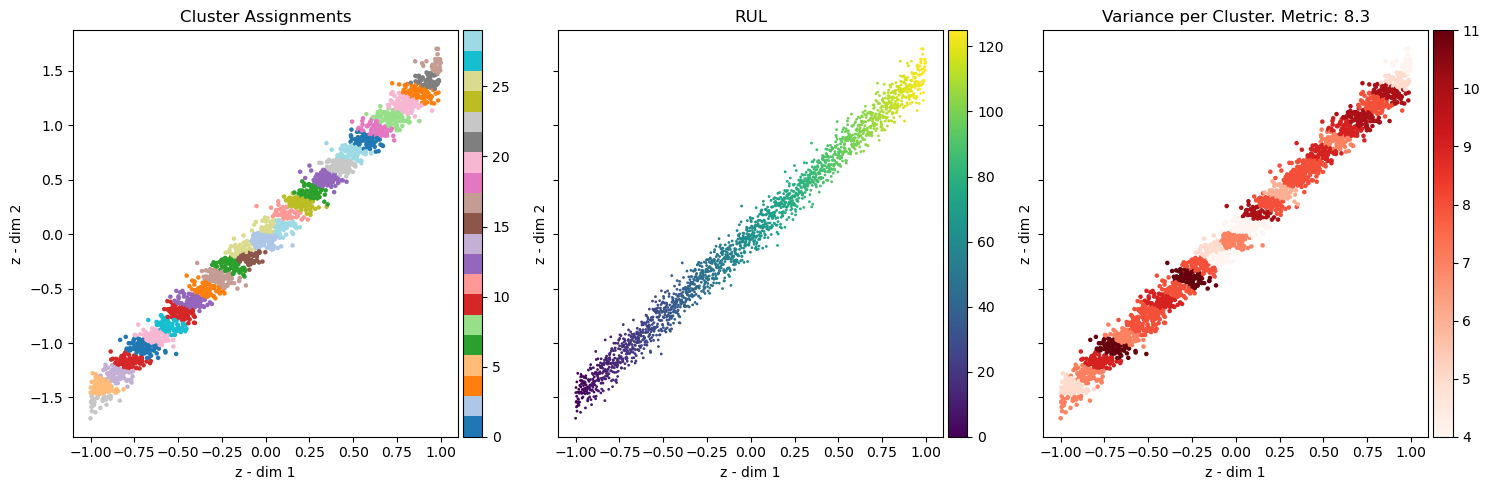

In [78]:
x1 = np.arange(-1, 1, 0.001)
x2 = 1.5 * x1 + np.random.normal(0, 0.1, len(x1))
z = np.stack([x1,x2]).T
y = 125*(x1+1)/2
y = y.clip(0, 125)
cluster(z, y, n_clusters=30)

metric 138.92424


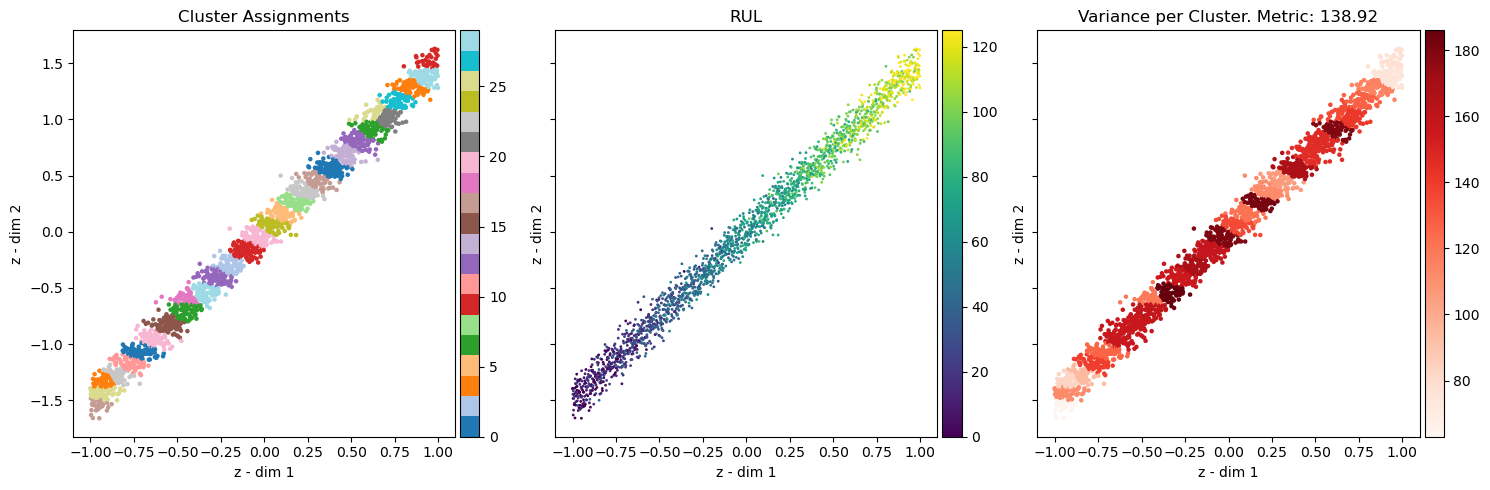

In [81]:
x1 = np.arange(-1, 1, 0.001)
x2 = 1.5 * x1 + np.random.normal(0, 0.1, len(x1))
z = np.stack([x1,x2]).T
y = 125*(x1+1 + np.random.normal(0, .2, len(x1)))/2
y = y.clip(0, 125)
cluster(z, y, n_clusters=30)

metric 669.1626


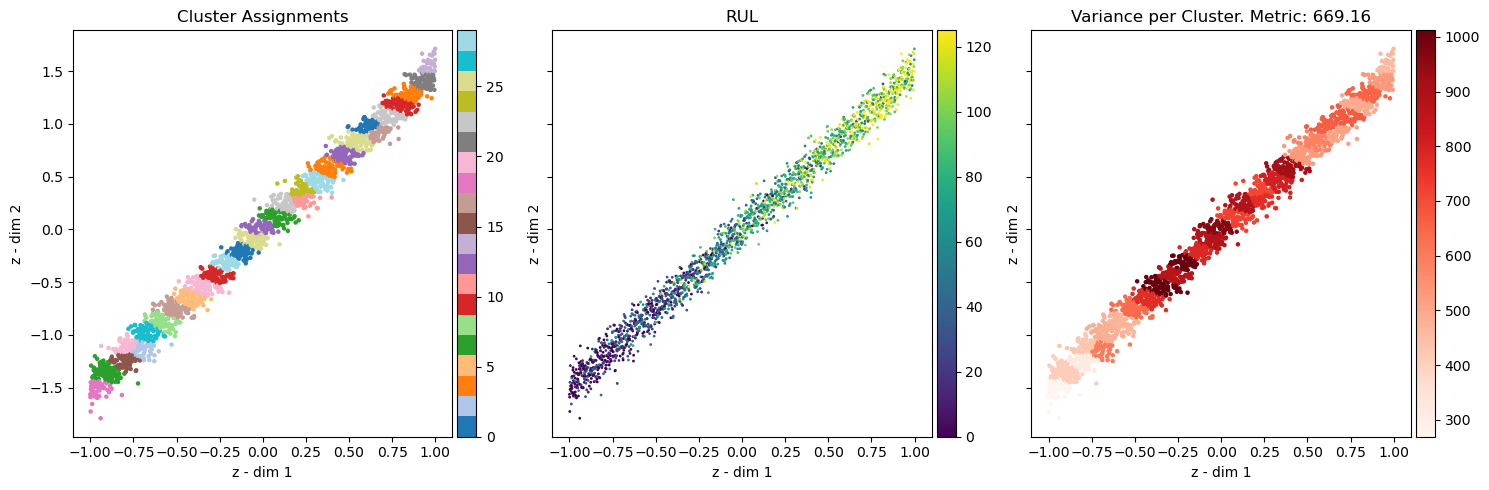

In [82]:
x1 = np.arange(-1, 1, 0.001)
x2 = 1.5 * x1 + np.random.normal(0, 0.1, len(x1))
z = np.stack([x1,x2]).T
y = 125*(x1+1 + np.random.normal(0, .5, len(x1)))/2
y = y.clip(0, 125)
cluster(z, y, n_clusters=30)

(2000, 2)
(4000, 2)
metric 11.91581


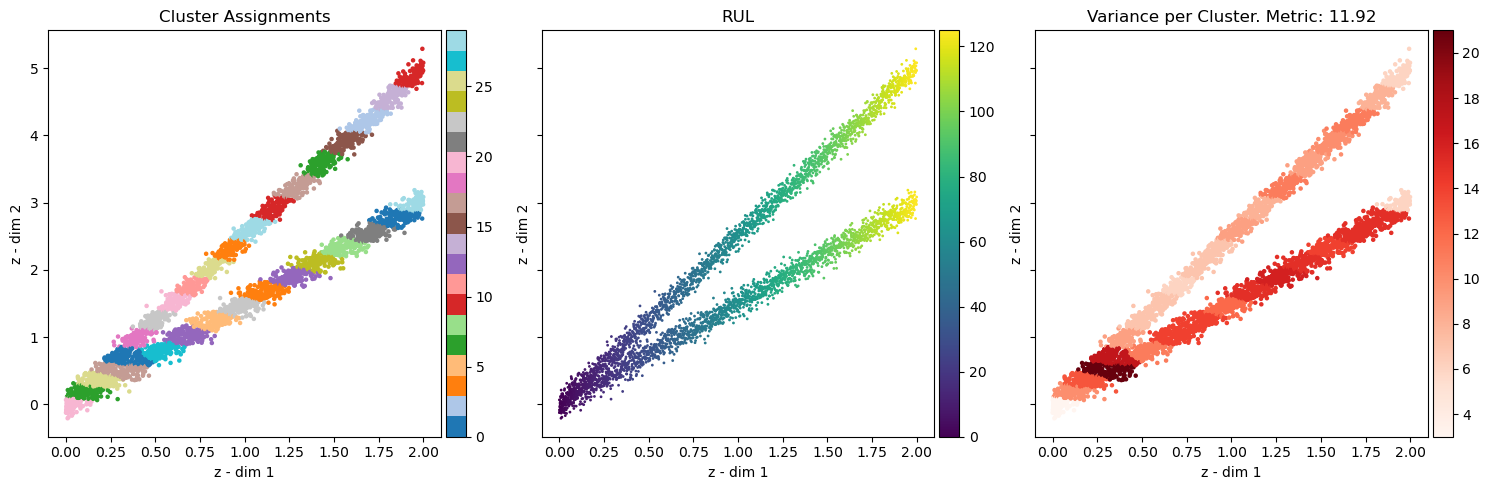

In [89]:
x1 = np.arange(0, 2, 0.001)
x2 = 1.5 * x1 + np.random.normal(0, 0.1, len(x1))
x3 = 2.5 * x1 + np.random.normal(0, 0.1, len(x1))
z = np.stack([x1,x2]).T
print(z.shape)
z = np.vstack([z, np.stack([x1,x3]).T])
print(z.shape)
y = 125*(z[:,0] )/2
y = y.clip(0, 125)
cluster(z, y, n_clusters=30)

(2000, 2)
(4000, 2)
metric 152.76046


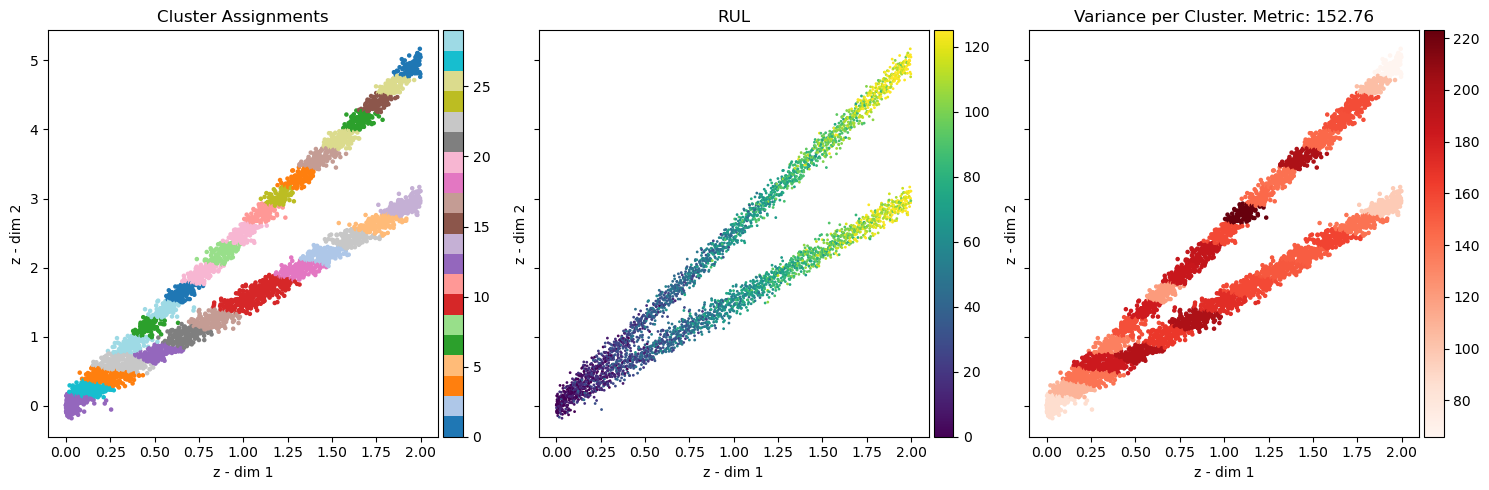

In [88]:
x1 = np.arange(0, 2, 0.001)
x2 = 1.5 * x1 + np.random.normal(0, 0.1, len(x1))
x3 = 2.5 * x1 + np.random.normal(0, 0.1, len(x1))
z = np.stack([x1,x2]).T
print(z.shape)
z = np.vstack([z, np.stack([x1,x3]).T])
print(z.shape)
y = 125*(z[:,0] + np.random.normal(0, .2, len(z[:,0])))/2
y = y.clip(0, 125)
cluster(z, y, n_clusters=30)

(2000, 2)
(4000, 2)
metric 725.98839


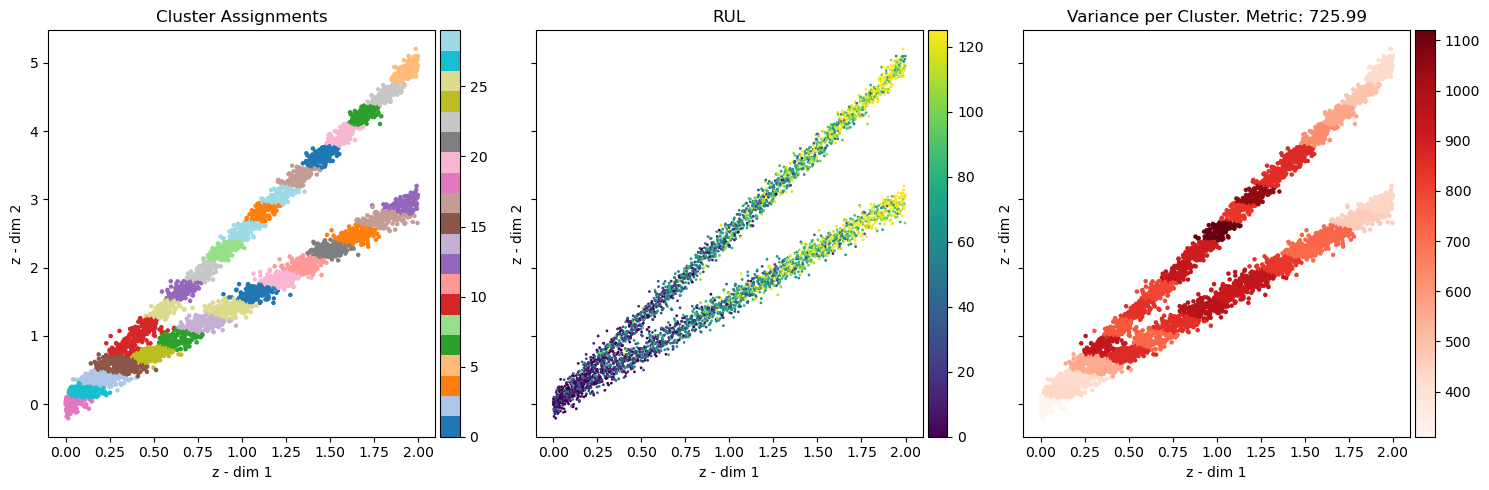

In [90]:
x1 = np.arange(0, 2, 0.001)
x2 = 1.5 * x1 + np.random.normal(0, 0.1, len(x1))
x3 = 2.5 * x1 + np.random.normal(0, 0.1, len(x1))
z = np.stack([x1,x2]).T
print(z.shape)
z = np.vstack([z, np.stack([x1,x3]).T])
print(z.shape)
y = 125*(z[:,0] + np.random.normal(0, .5, len(z[:,0])))/2
y = y.clip(0, 125)
cluster(z, y, n_clusters=30)

### CMAPSS Examples:

In [48]:
def run_metric(args, n_runs=3):
    
    dataset_name = args["dataset_name"]

    if dataset_name in {"FD001", "FD003"} :
        sensors = ['s_3', 's_4', 's_7', 's_11', 's_12'] #FD001 FD003
    elif dataset_name == "FD004":
        sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD004
    elif dataset_name == "FD002":
        sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12'] #FD002
    else:
        raise Exception(f"No such dataset: {dataset_name}")
    #sensors = [f's_{i}' for i in range(1,22)]

    input_size = len(sensors)


    for _ in range(n_runs):

        model = ERVE(input_size, **args["model_args"])

        trainer, *_, val_loader = get_trainer(dataset_name, sensors, model=model, **args["get_trainer_args"])
        trainer.train(**args["trainer_args"])

        z, y = get_z_space(model, val_loader,  save=False, show=True)

        cluster(z, y, n_clusters=30)


metric 220.53164
metric 200.99396
metric 232.99484


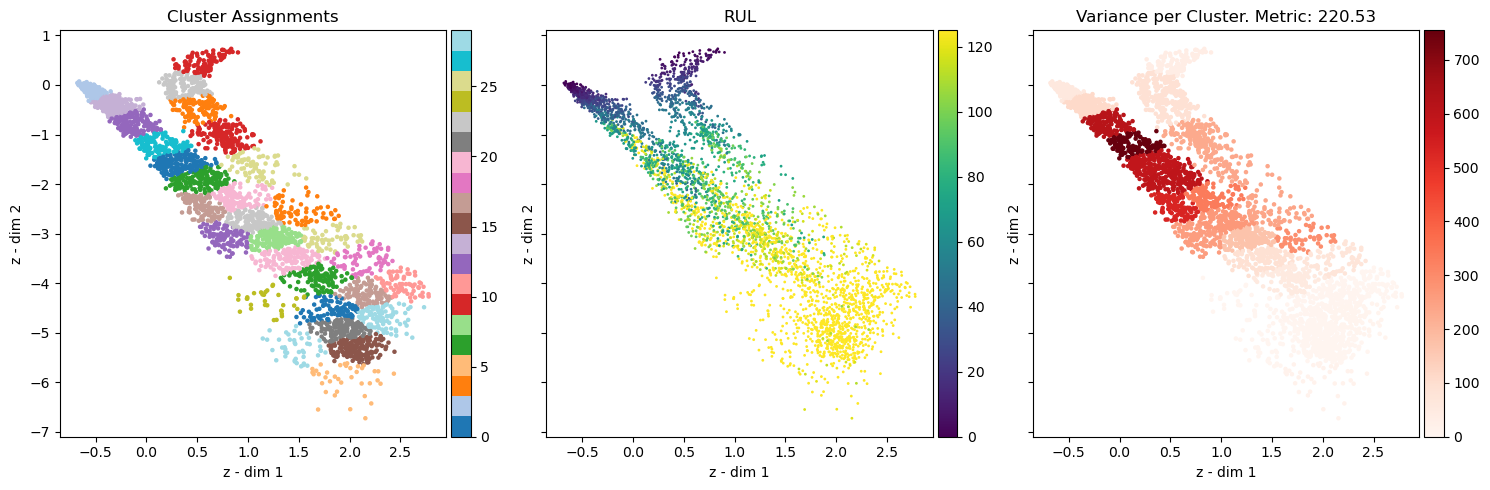

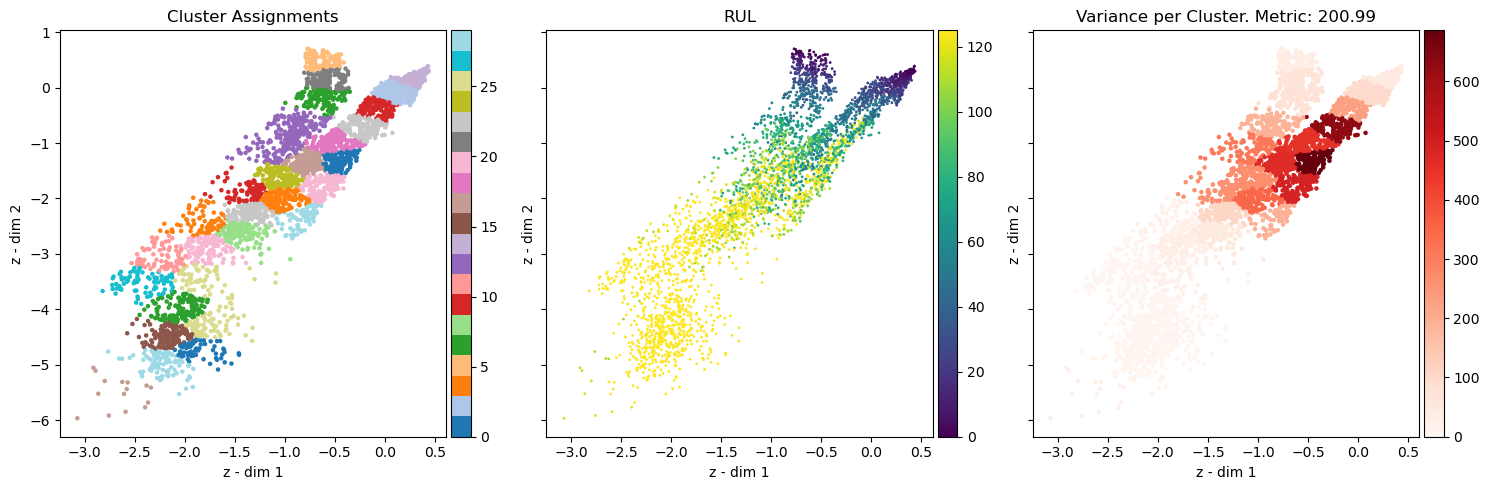

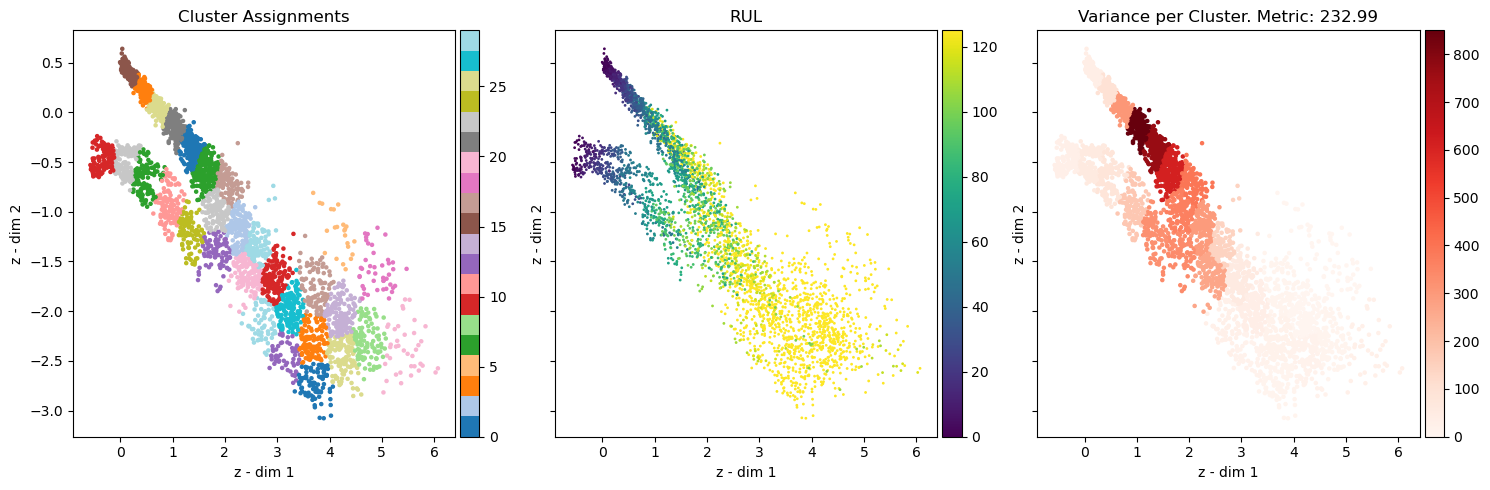

In [55]:
args = {
    "dataset_name": "FD003", 
    "model_args": {
        "hidden_size": 150, 
        "dropout": 0.7, 
        "bidirectional": True, 
        "decode_mode": True, 
        "reg_loss": True, 
        "kl_loss": True, 
        "recon_loss": True
        },
    "get_trainer_args": {
        "lr": 0.001, 
        "alpha": 1., 
        "verbose":False
        },
    "trainer_args" :{"n_epoch": 15}
    }

run_metric(args, n_runs=3)

metric 262.52338
metric 243.37048
metric 238.83094


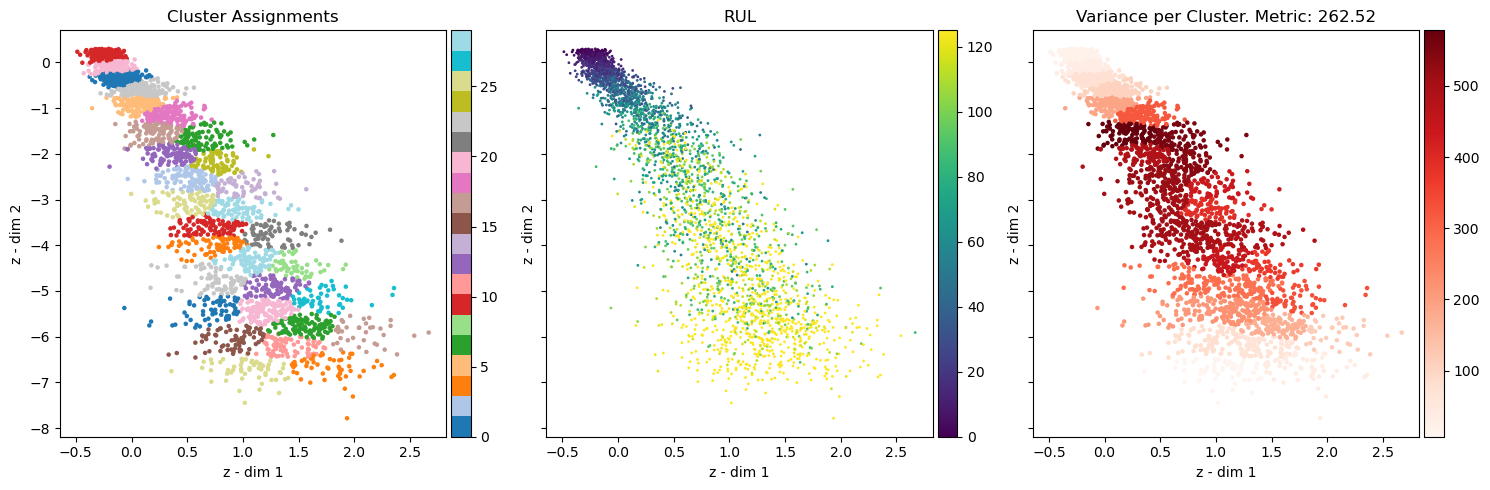

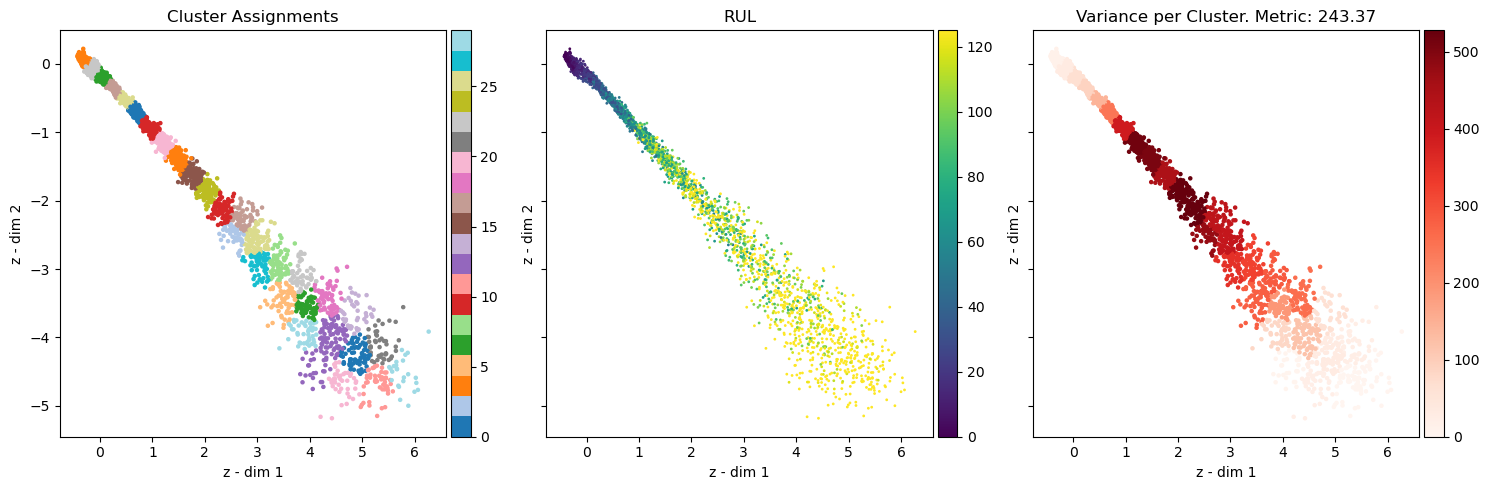

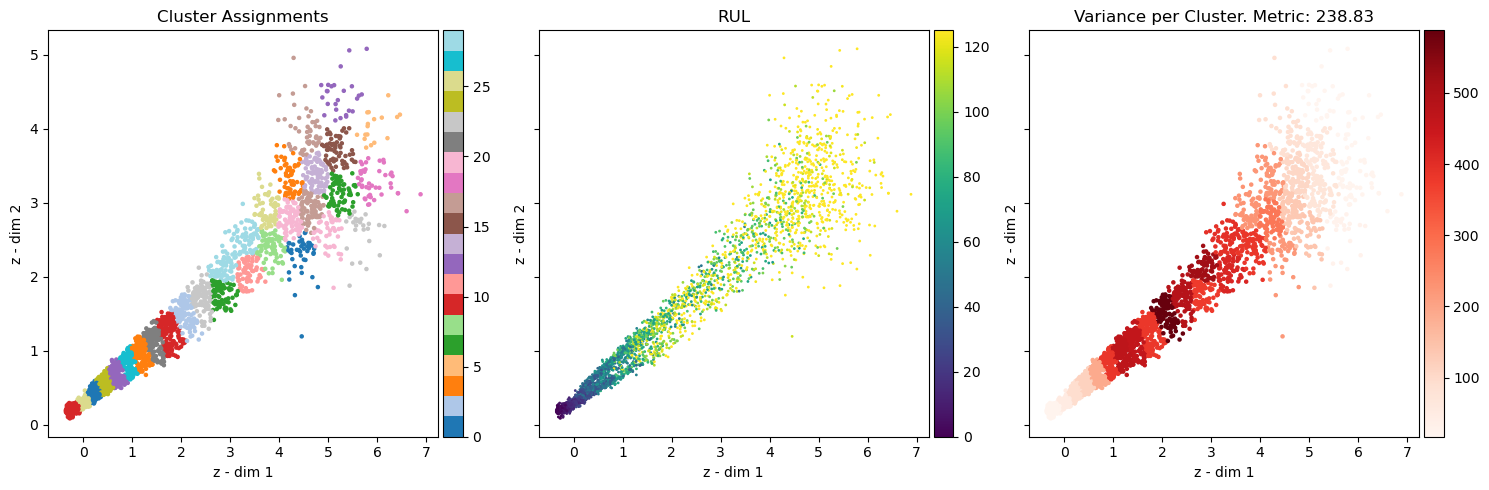

In [56]:
args = {
    "dataset_name": "FD001", 
    "model_args": {
        "hidden_size": 150, 
        "dropout": 0.7, 
        "bidirectional": True, 
        "decode_mode": False, 
        "reg_loss": True, 
        "kl_loss": True, 
        "recon_loss": False
        },
    "get_trainer_args": {
        "lr": 0.001, 
        "alpha": 1., 
        "verbose":False
        },
    "trainer_args" :{"n_epoch" :15}
    }

run_metric(args, n_runs=3)